In [1]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

import numpy as np

In [2]:
trc = torch.load("tracker_file.txt")

C:\Users\Jahid\AppData\Local\Temp\ipykernel_2556\1210481692.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trc = torch.load("tracker_file.txt")


In [3]:
list(trc.keys())

['input',
 'steps',
 'start_layer',
 'output',
 'one_hot',
 'final_blk_attn_shape',
 'R_before_block_ops',
 'Attention_Perception',
 'AP_R_after_modelwise_transformation',
 'Reasoning_Feeback',
 'W_state',
 'R_after_resfeedback',
 'R_final']

In [4]:
odir = "run/individual_tests"

### Input Visualization

Text(0.5, 1.0, 'Input Image')

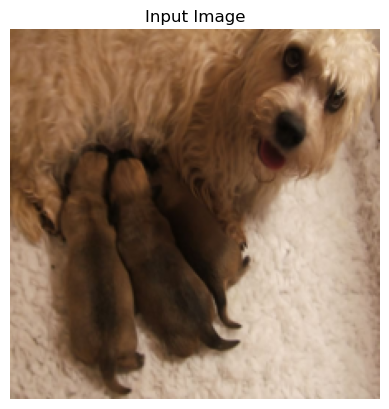

In [5]:
from PIL import Image


# Inverse the normalization -- copied from: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/5
inv_normalize = transforms.Normalize( 
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)


x = trc['input'][0]
x = inv_normalize(x)
x = torch.permute(x, (1, 2, 0))
x = x.detach().numpy()

plt.imshow(x)
plt.axis("off")
plt.title("Input Image")

### Output class index by the model

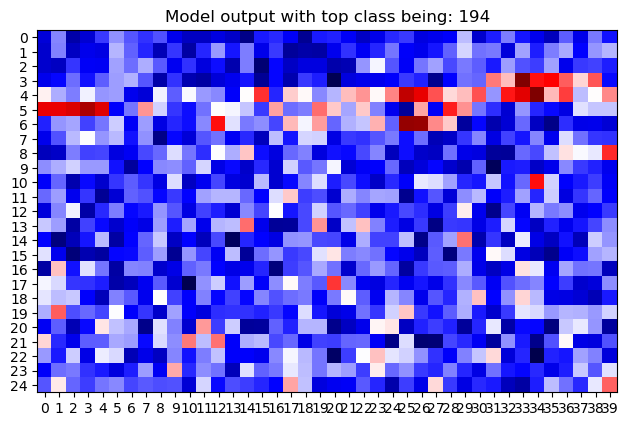

In [6]:
mo_arr = trc['output'].reshape(25, 40).detach().numpy()
plt.imshow(mo_arr, cmap="seismic")
plt.rcParams['figure.figsize'] = (int(25 * 1.5), int(40 * 1.5))
plt.xticks(range(0, 40))
plt.yticks(range(0, 25))
plt.title(f"Model output with top class being: {np.argmax(mo_arr)}")
plt.tight_layout()
plt.savefig("run/individual_tests/model_output_as_image_40x60.png")

In [7]:
trc['one_hot']

tensor(13.1452, requires_grad=True)

In [8]:
trc['final_blk_attn_shape']

# 14 * 14 => 196 tokens. Then 1 CLS token. Total 197 tokens.

torch.Size([1, 12, 197, 197])

Text(0.5, 1.0, 'R is identity matrix')

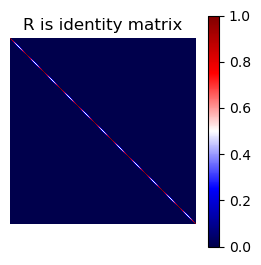

In [9]:
plt.rcParams['figure.figsize'] = (3,3)
plt.imshow(trc['R_before_block_ops'].detach().numpy()[0], cmap="seismic")
plt.axis("off")
plt.colorbar()
plt.title("R is identity matrix")

# **2. Attention Perception Investigation**

In [10]:
ap = trc['Attention_Perception']

list(ap.keys())

['rOps_3',
 'rOps_4',
 'rOps_5',
 'rOps_6',
 'rOps_7',
 'rOps_8',
 'rOps_9',
 'rOps_10',
 'rOps_11']

In [11]:
list(ap['rOps_3'].keys())

['z', 'm', 'order', 'vproj', 'cam_noreshape', 'mean_cam', 'O', 'R']

#### **2.1) Input `Z`**

In [12]:
def z_viz(ops_idx=3):
    z = ap[f'rOps_{ops_idx}']['z'][0].detach().numpy()

    zMin = round(z.min(), 2)
    zMax = round(z.max(), 2)
    zMean = round(z.mean(), 2)
    zStd = round(z.std(), 2)

    plt.rcParams['figure.figsize'] = (10,15)
    plt.imshow(z, cmap="seismic")
    plt.title(f"Z for layer {ops_idx}. Shape: {z.shape}.")
    plt.xlabel(f"Value Range: ({zMin}, {zMax}). \nMean: {zMean}, Std: {zStd}")
    plt.savefig(f"{odir}/rOps{ops_idx}_z.png")

#### **2.2) V with projection weight $W = W_{v} * W_{O}$**

In [13]:
def vproj_viz(ops_idx=3):
    vproj = ap[f'rOps_{ops_idx}']['vproj'][0].detach().numpy()

    vprojMin = round(vproj.min(), 2)
    vprojMax = round(vproj.max(), 2)
    vprojMean = round(vproj.mean(), 2)
    vprojStd = round(vproj.std(), 2)

    plt.rcParams['figure.figsize'] = (10,15)
    plt.imshow(vproj, cmap="seismic")
    plt.title(f"Vproj for layer {ops_idx}. Shape: {vproj.shape}.")
    plt.xlabel(f"Value Range: ({vprojMin}, {vprojMax}). \nMean: {vprojMean}, Std: {vprojStd}")
    plt.savefig(f"{odir}/rOps{ops_idx}_vproj.png")

#### **2.3) Order i.e. $\alpha_{i}$ visualization**

Formula used: $$ \alpha_{i} = \frac{||(Z^{l-1}W^(l))_{i,.}||}{||Z_i^(l-1)||}$$

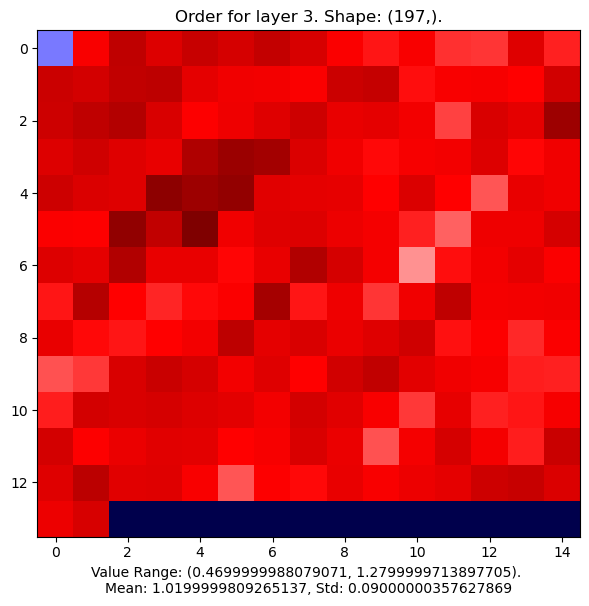

In [14]:
def order_viz(ops_idx=3):
    order3 = ap[f'rOps_{ops_idx}']['order'].detach().numpy() # So, this is just importance to each token. No importance on pixel then lmao.

    order3Min = round(order3.min(), 2)
    order3Max = round(order3.max(), 2)
    order3Mean = round(order3.mean(), 2)
    order3Std = round(order3.std(), 2)

    # We would reshape to (14, 15) image. But 14 * 15 = 210. We have 197 values. need 13 zeros to pad at the end.
    order3_padded = np.pad(order3, pad_width=(0, 13), mode="constant", constant_values=0)
    order3_padded = order3_padded.reshape(14, 15)

    plt.rcParams['figure.figsize'] = (7,7)
    plt.imshow(order3_padded, cmap="seismic")
    plt.title(f"Order for layer {ops_idx}. Shape: {order3.shape}.")
    plt.xlabel(f"Value Range: ({order3Min}, {order3Max}). \nMean: {order3Mean}, Std: {order3Std}")
    plt.savefig(f"{odir}/rOps{ops_idx}_order.png")
    
    
order_viz(3)

#### **2.4) `m` i.e. diagonal matrix of `Order` visualization**

In [15]:
def m_viz(ops_idx=3):
    m = ap[f'rOps_{ops_idx}']['m'].detach().numpy()

    mMin = round(m.min(), 2)
    mMax = round(m.max(), 2)
    mMean = round(m.mean(), 2)
    mStd = round(m.std(), 2)

    plt.rcParams['figure.figsize'] = (5, 5)
    plt.imshow(m, cmap="seismic")
    plt.title(f"m for layer {ops_idx}. Shape: {m.shape}.")
    plt.xlabel(f"Value Range: ({mMin}, {mMax}). \nMean: {mMean}, Std: {mStd}")
    plt.savefig(f"{odir}/rOps{ops_idx}_m.png")

#### **2.5) Activation map visualization**

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def raw_attention_viz(ops_idx=3):
    cam = ap[f'rOps_{ops_idx}']['cam_noreshape'][0].detach().numpy()

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(80, 60))
    
    for i in range(3):
        for j in range(4):
            idx = i * 4 + j
            if idx < cam.shape[0]:
                ax = axes[i, j]
                single_cam = cam[idx]
                
                camMin = round(single_cam.min(), 2)
                camMax = round(single_cam.max(), 2)
                camMean = round(single_cam.mean(), 2)
                camStd = round(single_cam.std(), 2)

                ax.imshow(single_cam, cmap="seismic")
                ax.set_title(f"Map: {(i*4) + j}")
                ax.set_xlabel(f"Min: {camMin}, Max: {camMax}\n Mean: {camMean}, Std: {camStd}")
            else:
                ax.axis('off') 
    plt.suptitle(f"CAMs for layer {ops_idx}", fontsize=16)
    plt.tight_layout() 
    plt.savefig(f"{odir}/rOps{ops_idx}_raw_attention.png")
    plt.clf()

#### **2.6) Mean Activation map visualization**

In [42]:
def mean_attention_viz(ops_idx=3, colormap = "Reds"):
    cam_mean = ap[f'rOps_{ops_idx}']['mean_cam'].detach().numpy()

    cam_meanMin = round(cam_mean.min(), 2)
    cam_meanMax = round(cam_mean.max(), 2)
    cam_meanMean = round(cam_mean.mean(), 2)
    cam_meanStd = round(cam_mean.std(), 2)


    plt.rcParams['figure.figsize'] = (40,40)
    plt.imshow(cam_mean, cmap=colormap)
    plt.title(f"Mean attention for layer {ops_idx}. Shape: {cam_mean.shape}.")
    plt.xlabel(f"Value Range: ({cam_meanMin}, {cam_meanMax}). \nMean: {cam_meanMean}, Std: {cam_meanStd}")
    plt.savefig(f"{odir}/rOps{ops_idx}_mean_attention__color_{colormap}.png")
    plt.colorbar()
    plt.clf()

#### **2.7) O of the operation**

In [32]:
def o_value_viz(ops_idx=3):
    o_value_mean = ap[f'rOps_{ops_idx}']['O'].detach().numpy()

    o_value_meanMin = round(o_value_mean.min(), 2)
    o_value_meanMax = round(o_value_mean.max(), 2)
    o_value_meanMean = round(o_value_mean.mean(), 2)
    o_value_meanStd = round(o_value_mean.std(), 2)


    plt.rcParams['figure.figsize'] = (30,30)
    plt.imshow(o_value_mean, cmap="seismic")
    plt.title(f"O value for layer {ops_idx}. Shape: {o_value_mean.shape}.")
    plt.xlabel(f"Value Range: ({o_value_meanMin}, {o_value_meanMax}). \nMean: {o_value_meanMean}, Std: {o_value_meanStd}")
    plt.savefig(f"{odir}/rOps{ops_idx}_o_value.png")
    plt.colorbar()
    plt.clf()

#### **2.8) Current state's Relevance i.e. $O + I$**

In [33]:
def curr_rel_viz(ops_idx=3):
    curr_rel_mean = ap[f'rOps_{ops_idx}']['O'].detach().numpy()
    curr_rel_mean = curr_rel_mean + np.identity(curr_rel_mean.shape[0])

    curr_rel_meanMin = round(curr_rel_mean.min(), 2)
    curr_rel_meanMax = round(curr_rel_mean.max(), 2)
    curr_rel_meanMean = round(curr_rel_mean.mean(), 2)
    curr_rel_meanStd = round(curr_rel_mean.std(), 2)


    plt.rcParams['figure.figsize'] = (30,30)
    plt.imshow(curr_rel_mean, cmap="seismic")
    plt.title(f"O value for layer {ops_idx}. Shape: {curr_rel_mean.shape}.")
    plt.xlabel(f"Value Range: ({curr_rel_meanMin}, {curr_rel_meanMax}). \nMean: {curr_rel_meanMean}, Std: {curr_rel_meanStd}")
    plt.savefig(f"{odir}/rOps{ops_idx}_current_relevence_OplusIdentity.png")
    plt.colorbar()
    plt.clf()

#### **2.9) Model's relevance at this stage**

In [34]:
def accumulated_rel_viz(ops_idx=3):
    accumulated_rel_mean = ap[f'rOps_{ops_idx}']['R'][0].detach().numpy()  # Shape was: (batch_size, num_tokens, num_tokens)
    accumulated_rel_mean = accumulated_rel_mean + np.identity(accumulated_rel_mean.shape[0])

    accumulated_rel_meanMin = round(accumulated_rel_mean.min(), 2)
    accumulated_rel_meanMax = round(accumulated_rel_mean.max(), 2)
    accumulated_rel_meanMean = round(accumulated_rel_mean.mean(), 2)
    accumulated_rel_meanStd = round(accumulated_rel_mean.std(), 2)


    plt.rcParams['figure.figsize'] = (30,30)
    plt.imshow(accumulated_rel_mean, cmap="seismic")
    plt.title(f"O value for layer {ops_idx}. Shape: {accumulated_rel_mean.shape}.")
    plt.xlabel(f"Value Range: ({accumulated_rel_meanMin}, {accumulated_rel_meanMax}). \nMean: {accumulated_rel_meanMean}, Std: {accumulated_rel_meanStd}")
    plt.savefig(f"{odir}/rOps{ops_idx}_accumulated_relevence.png")
    plt.colorbar()
    plt.clf()

# **2.11 Calculating all the features for all available blocks**

In [35]:
import time
from tqdm import tqdm

blks = tqdm(range(3, 12))


# def attention_perception_operations_viz():
#     for bl in tqdm(block_numbers):
#         z_viz(bl)
#         vproj_viz(bl)
#         order_viz(bl)
#         m_viz(bl)
#         raw_attention_viz(bl)
#         mean_attention_viz(bl)
#         o_value_viz(bl)
#         curr_rel_viz(bl)
#         accumulated_rel_viz(bl)
        
    
#     print("All visuals saved")

  0%|          | 0/9 [00:00<?, ?it/s]

In [49]:
# for bl in blks:
#     z_viz(bl)
    
# for bl in blks:
#     vproj_viz(bl)

# for bl in blks:
#     m_viz(bl)

# for bl in blks:
#     order_viz(bl)

for bl in blks:
    raw_attention_viz(bl)
    time.sleep(5)

# for bl in blks:
#     mean_attention_viz(bl)
#     time.sleep(2)


# for bl in blks:
#     o_value_viz(bl)
#     time.sleep(2)

# for bl in blks:
#     accumulated_rel_viz(bl)
#     time.sleep(2)

<Figure size 8000x6000 with 0 Axes>

<Figure size 8000x6000 with 0 Axes>

<Figure size 8000x6000 with 0 Axes>

<Figure size 8000x6000 with 0 Axes>

<Figure size 8000x6000 with 0 Axes>

<Figure size 8000x6000 with 0 Axes>

<Figure size 8000x6000 with 0 Axes>

<Figure size 8000x6000 with 0 Axes>

<Figure size 8000x6000 with 0 Axes>